Style GAN

In [60]:
#import stuff
#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Flatten, Conv2D, LeakyReLU, AveragePooling2D, Add, Input, InputSpec, UpSampling2D, Activation, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.optimizers import *
from tensorflow.python.keras.utils import conv_utils
#other stuff
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os
from IPython import display
from PIL import Image

Parameters

In [2]:
batch_size = 8
depth = 16          #filters
latent_size = 64    #size of input vector z
im_size = 256       #final image size
n_layers = 8        #no. layers in the synthesis network

Load and process the data

In [3]:
#load raw data
raw_ds = tf.keras.preprocessing.image_dataset_from_directory('D:\Datasets\keras_png_slices_data\keras_png_slices_train', labels=None, color_mode='grayscale', batch_size=batch_size)
print(raw_ds)

#check range of values in raw data
image_batch = next(iter(raw_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

#normalise the data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)
norm_ds = raw_ds.map(lambda img: (normalization_layer(img)))

#check range of values in raw data
image_batch = next(iter(norm_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


Found 9664 files belonging to 1 classes.
<BatchDataset shapes: (None, 256, 256, 1), types: tf.float32>
0.0 255.0
-1.0 1.0


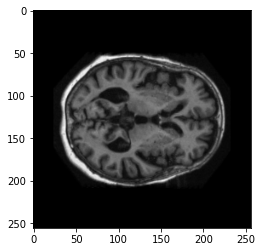

In [4]:
#visualise raw data
for images in raw_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

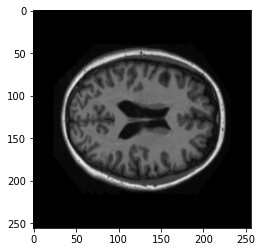

In [5]:
#visualise norm data
for images in norm_ds.take(1):
    plt.imshow(images[0].numpy().astype("float32"), cmap='gray')
    plt.show()

Networks

In [6]:
#Conv2DMod layer
#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/989306792ca49dcbebb353c4f06c7b48aeb3a9e3/conv_mod.py#L15

class ModConv2D (keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=(1,1), padding = 'valid', kernel_initializer='glorot_uniform', 
                    kernel_regularizer=None, activity_regularizer=None, kernel_constraint=None, demod = True, **kwargs):
        #define all the parameters of the layer
        super(ModConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.rank = 2
        self.kernel_size= conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
        self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
        self.padding = conv_utils.normalize_padding(padding)
        #?
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        #?
        self.demod = demod

        #input with ndim=4 is previous convolution layer
        #input with ndim=2 is the input style for this layer (output from style generator)
        self.Input_spec = [InputSpec(ndim=4), InputSpec(ndim=2)]


    def build(self, input_shape):
        #define weights after shape of input is known
        channel_axis = -1
        input_dim = input_shape[0][channel_axis] #should be 1 for this dataset since it's only grayscale images being sent through the system
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel = self.add_weight(shape=kernel_shape, initializer=self.kernel_initializer, name='kernel', 
                                        regularizer=self.kernel_regularizer, constraint=self.kernel_constraint)

        #input specifications
        #input_shape[0] is the output of the previous layer
        #input_shape[1] is the style
        self.input_spec = [InputSpec(ndim=4, axes={channel_axis: input_dim}), InputSpec(ndim=2)]

        self.built = True


    def call(self, inputs):
        #execute the code when the layer is used
            #modulation stuff
        style = inputs[1]
        #print("style shape:", style.shape)
        #print("kernel shape:", self.kernel.shape)

        #make the input style W shape compatible with kernel
        inp_mods = K.expand_dims(K.expand_dims(K.expand_dims(style, axis = 1), axis = 1), axis = -1)
        my_kernel = K.expand_dims(self.kernel, axis=0)

        #modulate
        #print("kernel", (int)(tf.rank(my_kernel)), my_kernel.shape)
        #print("kernel shape:", my_kernel.shape)
        #print("input style", (int)(tf.rank(inp_mods)), inp_mods.shape)
        #print("input style shape:", inp_mods.shape)
        weights = my_kernel * (inp_mods + 1)
        #weights = 0

        #demodulate
        if self.demod:
            weights /= K.sqrt(K.sum(K.square(weights), axis=[1,2,3], keepdims = True) + 1e-8)
        
        x = tf.transpose(inputs[0], [0,3,1,2])
        x = tf.reshape(x, [1, -1, x.shape[2], x.shape[3]])

        w = tf.transpose(weights, [1,2,3,0,4])
        w = tf.reshape(w, [weights.shape[1], weights.shape[2], weights.shape[3], -1])

        #normal convolution 2d
        #data is stored in [batch_size, channels, height, width]
        x = tf.nn.conv2d(x, w, strides=self.strides, padding='SAME', data_format='NCHW')

        #print(x.shape)

        x = tf.reshape(x, [-1, self.filters, tf.shape(x)[2], tf.shape(x)[3]]) # Fused => reshape convolution groups back to minibatch.
        x = tf.transpose(x, [0, 2, 3, 1])

        return x

In [7]:
#define generator
#mapping network
    #for taking an image (style) and converting it to latent space to use in the weights of the synthesis network
#synthesis network
    #network used to generate images using input style and noise
    #skip connections

#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/master/stylegan_two.py

def noise(n):
    return np.random.normal(0.0, 1.0, size = [n, latent_size]).astype('float32')

def noiseList(n):
    return [noise(n)] * n_layers

def crop_to_fit(x):
    #makes sure that x[0] has the same dimensions as x[1]
    height = x[1].shape[1]
    width = x[1].shape[2]

    return x[0][:, :height, :width, :]

def make_output_size(s1=4, s2=im_size):
    ss = int(s2 / s1)
    #print(ss)
    def upsample_to_size(x, y = ss):
        x = K.resize_images(x, y, y, "channels_last", interpolation='bilinear')
        #print(x.shape)
        return x
    return upsample_to_size

def to_output(inputs, style):
    #want to do a ModConv2D on input with styles like norma;
    size = inputs.shape[2]
    #print(inputs.shape, size)
    x = ModConv2D(1, 1, kernel_initializer=VarianceScaling(200/size), demod=False)([inputs, style])
    #upsample image to be (None, im_size, im_size, None)
    #print(x.shape)
    return Lambda(make_output_size(size, im_size), output_shape=[None, im_size, im_size, None])(x)

def make_style_generator():
    #standard deep NN
    model = tf.keras.Sequential()
    model.add(Dense(512, input_shape=[latent_size]))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))

    return model

def g_block(inputs, input_style, input_noise, filters, upsampling=True):

    #optional upsampling
    if upsampling:
        out = UpSampling2D(interpolation='bilinear')(inputs)
    else:
        out = Activation('linear')(inputs)

    #residual
    out_style = Dense(filters, kernel_initializer = VarianceScaling(200/out.shape[2]))(input_style)

    #main block
    #style stuff
    style = Dense(inputs.shape[-1], kernel_initializer = 'he_uniform')(input_style)
    delta = Lambda(crop_to_fit)([input_noise, out])
    d = Dense(filters, kernel_initializer='zeros')(delta)

    #ModConv2D block
    out = ModConv2D(filters, (3,3), strides=(1,1), padding="same", kernel_initializer = 'he_uniform')([out, style])
    out = Add()([out, d])
    out = LeakyReLU(0.2)(out)

    return out, to_output(out, out_style)


def make_synthesis_network ():
    #Inputs
    input_styles = []
    #input_noises = []
    for i in range(n_layers):
        input_styles.append(Input(shape=[512]))

    input_noise = Input(shape=[im_size, im_size, 1])
    outs = []

    x = Lambda(lambda x: x[:, :1]*0 + 1)(input_styles[0])

    x = Dense(4*4*4*depth, activation='relu', kernel_initializer='random_normal')(x) #learned constant input vector
    x = Reshape([4, 4, 4*depth])(x) #a [4, 4, 4*depth] tensor --> to feed next layer of 4x4

    x, r = g_block(x, input_styles[1], input_noise, 64*depth, upsampling=False)    #4x4
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[2], input_noise, 32*depth)                      #8x8
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[3], input_noise, 16*depth)                      #16x16
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[4], input_noise, 8*depth)                       #32x32
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[5], input_noise, 4*depth)                       #64x64
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[6], input_noise, 2*depth)                       #128x128
    outs.append(r)
    #print(x.shape) #, r.shape)
    x, r = g_block(x, input_styles[7], input_noise, depth)                         #256x256
    outs.append(r)
    #print(x.shape) #, r.shape)
    """ 
    """

    x = Add()(outs)

    #normalise
    x = Lambda(lambda y: y/2 + 0.5)(x)

    print("end shape", x.shape)
    
    model = Model(inputs = [input_styles, input_noise], outputs = x)
    return model

def make_generator_model(S, G):
    input_z = []
    W = []
    for i in range(n_layers):
        input_z.append(Input([latent_size]))
        W.append(S(input_z[-1]))

    input_noise = Input([im_size, im_size, 1])

    generated_image = G((W, input_noise))
    
    gen_model = Model(inputs = [input_z, input_noise], outputs = generated_image)

    return gen_model

In [8]:
#make generator model
S = make_style_generator()
G = make_synthesis_network()

gen_model = make_generator_model(S, G)

#gen_model.summary()

end shape (None, None, None, 1)


In [9]:
gen_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 64)]         0                                            
____________________________________________________________________________________________

(8, 256, 256, 1)


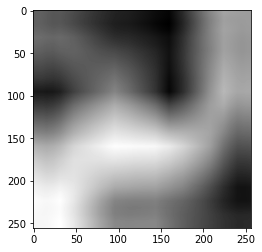

In [10]:
z = noiseList(batch_size)
w = []
for i in range(n_layers):
    w.append(S(z[i]))

added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
image = G((w, added_noise))
print(image.shape)
plt.imshow(image[0].numpy().astype("float32"), cmap='gray')

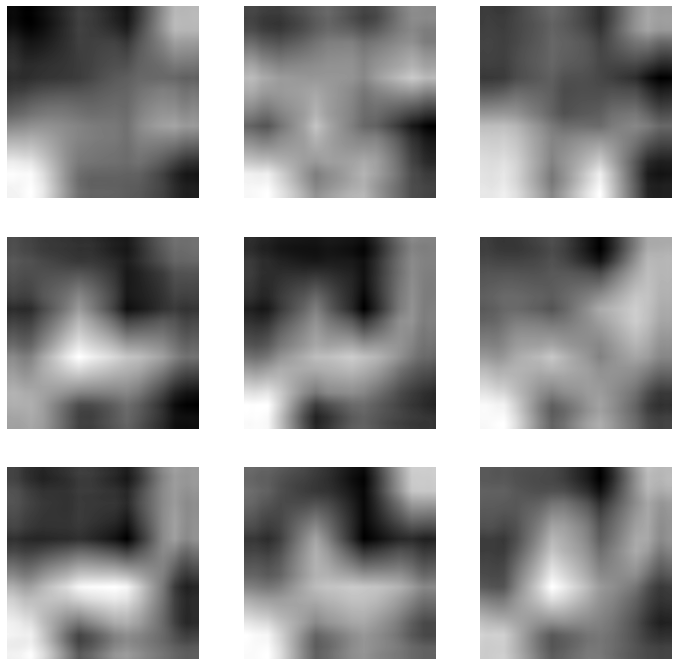

In [11]:
#check mode collapse
fig = plt.figure(figsize=(12,12))
for i in range(9):
    #generate new images every time
    z = noiseList(batch_size)
    added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
    #images = gen_model((z, added_noise))
    w = []
    for z in z:
        z*=1.3
        w.append(S(z))
    images = G((w, added_noise*1))
    
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

In [12]:
#define discriminator
    #residual connections

#https://github.com/manicman1999/StyleGAN2-Tensorflow-2.0/blob/master/stylegan_two.py

def d_block(inputs, filters, pooling=True):
    residual = Conv2D(filters, 1)(inputs)

    out = Conv2D(filters, (3,3), padding='same')(inputs)
    out = LeakyReLU(0.2)(out)
    out = Conv2D(filters, (3,3), padding='same')(out)
    out = LeakyReLU(0.2)(out)

    out = Add()([residual, out])

    if pooling:
        out = AveragePooling2D()(out)

    return out

def make_discriminator_model():
    inputs = Input(shape=(im_size, im_size, 1))

    x = d_block(inputs, depth)
    x = d_block(x, depth * 2)
    x = d_block(x, depth * 4)
    x = d_block(x, depth * 8)
    x = d_block(x, depth * 16, pooling=False)

    #classification stuff
    x = Flatten()(x)
    x = Dense(1)(x)

    model = Model(inputs= inputs, outputs = x)

    return model

In [13]:
#create discriminator
D = make_discriminator_model()
D.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         input_19[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 2320        leaky_re_lu_11[0][0]             
____________________________________________________________________________________________

In [14]:
#test D
print(D(image)[0])

tf.Tensor([-0.3535607], shape=(1,), dtype=float32)


In [15]:
for image_batch in norm_ds.take(1):
    print(D(image_batch)[0])


tf.Tensor([0.22041307], shape=(1,), dtype=float32)


Training

In [16]:
#optimiser functions
gen_model_optimiser = Adam(learning_rate = 0.0001, beta_1 = 0, beta_2 = 0.999)
D_optimiser = Adam(learning_rate = 0.0001, beta_1 = 0, beta_2 = 0.999)

In [17]:
#saving
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_model_optimiser, discriminator_optimizer=D_optimiser, generator=gen_model, discriminator=D)

In [18]:
#seed for generating outputs for each epoch
z = noiseList(batch_size)
added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
seed = (z, added_noise)

In [19]:
#define training step
@tf.function
def train_step(images, style, noise, pl_mean):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #get style vectors
        w = []
        for i in range(len(style)):
            w.append(S(style[i]))
        #generated images
        gen_images = G((w, noise))

        #discriminate between the two
        more_noise = tf.random.normal([batch_size, im_size, im_size, 1])
        real_output = D(images + more_noise*0.1)
        fake_output = D(gen_images)

        #loss functions
        gen_loss = K.mean(fake_output)
        disc_loss = K.mean(K.relu(1+real_output) + K.relu(1 - fake_output))*0.9

        #gradient penalty
        #

        #path length regularisation
        w_2 = []
        for i in range(len(style)):
            #slightly adjust w
            std = 0.1 / (K.std(w[i], axis = 0, keepdims = True) + 1e-8)
            w_2.append(w[i] + K.random_normal(tf.shape(w[i])) / (std + 1e-8))
        #generate second set of images
        pl_images = G((w_2, noise))

        #get path length
        delta_g = K.mean(K.square(pl_images - gen_images), axis = [1, 2, 3])
        pl_lengths = delta_g

        if pl_mean > 0:
            gen_loss += K.mean(K.square(pl_lengths - pl_mean))

    #get gradients
    gen_gradients = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, D.trainable_variables)

    #apply gradients
    gen_model_optimiser.apply_gradients(zip(gen_gradients, gen_model.trainable_variables))
    D_optimiser.apply_gradients(zip(disc_gradients, D.trainable_variables))

    return disc_loss, gen_loss, pl_lengths

In [20]:
#define training loop
def train(dataset, epochs):
    disc_loss = []
    gen_loss = []
    pl_mean = 0
    for epoch in range(epochs):
        for image_batch in tqdm(dataset):
            #train step
            style = noiseList(batch_size)
            noise = tf.random.normal([batch_size, im_size, im_size, 1])
            a, b, d = train_step(image_batch, style, noise, pl_mean)
            #adjust path length mean
            if pl_mean == 0:
                pl_mean = K.mean(d)
            pl_mean = 0.98*pl_mean + 0.02*K.mean(d)
            
            disc_loss.append(a)
            gen_loss.append(b)
            
        display.clear_output(wait=True)
        #generate a plot of the outcomes from this epoch and save it
        generate_and_save_images(gen_model, epoch + 1, seed)
        #checkpoints
        save_freq = 10
        if (epoch + 1) % save_freq == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

    display.clear_output(wait=True)
    generate_and_save_images(gen_model, epochs, seed, save=False)
    return disc_loss, gen_loss

In [21]:
#generate and save images
def generate_and_save_images(model, epoch, test_input, save=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12, 12))

    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(hspace=-0.6, wspace=0.1)
    if save: plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

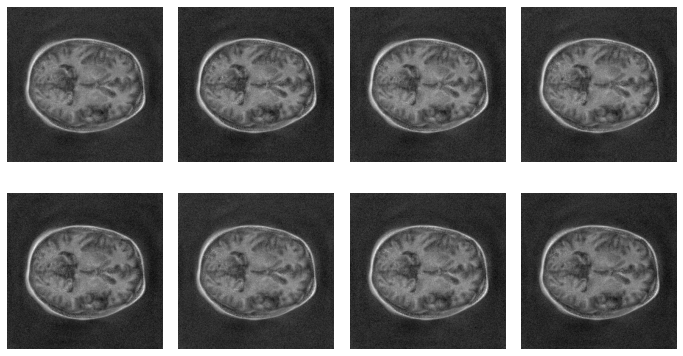

In [22]:
#run training loop
epochs = 30
losses = train(norm_ds, epochs)

In [23]:
#restore last checkpoint
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Visualise outcome

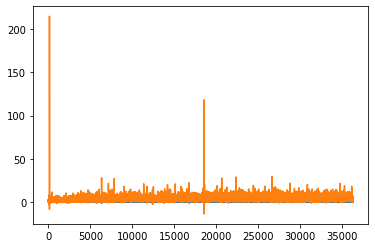

In [24]:
#print losses
#print(len(losses[0]), len(losses[1]))
x = np.arange(0, epochs*(9664/batch_size))
plt.plot(x, losses[0]) #blue    >discriminator loss
plt.plot(x, losses[1]) #orange  >generator loss
plt.show()

[ 0.9510316   0.5008958  -1.1679676  -0.25401825]


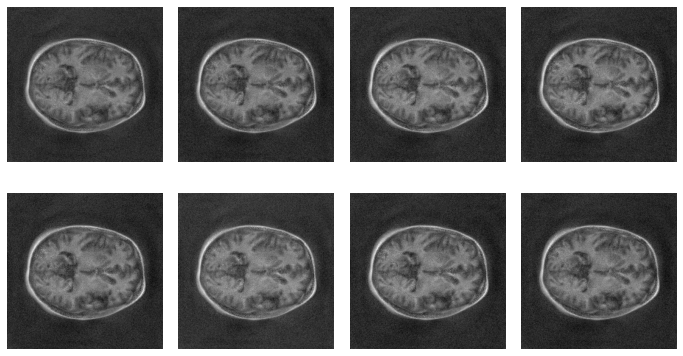

In [25]:
#inference
z = noiseList(batch_size)
print(z[0][0][0:4])
added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
images = gen_model((z, added_noise))

fig = plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=-0.6, wspace=0.1)
plt.show()

In [26]:
#losses = train(norm_ds, 1)

[<tf.Tensor: shape=(8, 512), dtype=float32, numpy=
array([[ 0.03085292, -0.5065175 ,  0.045693  , ..., -0.67758733,
         0.1105446 ,  0.14165987],
       [ 0.02544721, -0.49618858,  0.04589241, ..., -0.6488202 ,
         0.10251845,  0.12979503],
       [ 0.02672122, -0.48204902,  0.03793263, ..., -0.62686825,
         0.09938504,  0.13407211],
       ...,
       [ 0.02673491, -0.48622766,  0.04139511, ..., -0.6477426 ,
         0.105812  ,  0.1335566 ],
       [ 0.02872359, -0.4769338 ,  0.04349306, ..., -0.6426326 ,
         0.10678686,  0.1307588 ],
       [ 0.03297627, -0.50479853,  0.04431186, ..., -0.67141986,
         0.10033718,  0.13117772]], dtype=float32)>, <tf.Tensor: shape=(8, 512), dtype=float32, numpy=
array([[-0.00625055,  0.10261635, -0.00925703, ...,  0.13727371,
        -0.02239544, -0.02869914],
       [-0.0051554 ,  0.10052379, -0.00929743, ...,  0.13144572,
        -0.02076941, -0.02629542],
       [-0.0054135 ,  0.09765922, -0.00768485, ...,  0.12699842,
    

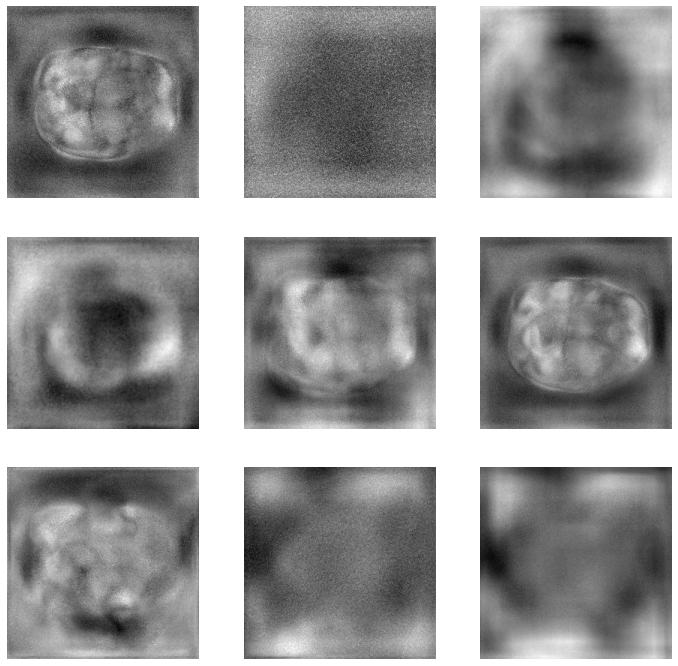

In [53]:
#check mode collapse
fig = plt.figure(figsize=(12,12))
for i in range(9):
    #generate new images every time
    z = noiseList(batch_size)
    added_noise = tf.random.normal((batch_size, im_size, im_size, 1))
    #images = gen_model((z, added_noise))
    w = []
    for z in z:
        z*=1
        new_w = S(z)
        rand_num = np.random.uniform(low=-1, high=1)
        new_w *= rand_num
        w.append(new_w)
    print(w)
    images = G((w, added_noise*1))
    
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

In [59]:
num =np.linspace(0,1,64)
num  = np.reshape(num, [1,64])
print(num)
print(S(num))

[[0.         0.01587302 0.03174603 0.04761905 0.06349206 0.07936508
  0.0952381  0.11111111 0.12698413 0.14285714 0.15873016 0.17460317
  0.19047619 0.20634921 0.22222222 0.23809524 0.25396825 0.26984127
  0.28571429 0.3015873  0.31746032 0.33333333 0.34920635 0.36507937
  0.38095238 0.3968254  0.41269841 0.42857143 0.44444444 0.46031746
  0.47619048 0.49206349 0.50793651 0.52380952 0.53968254 0.55555556
  0.57142857 0.58730159 0.6031746  0.61904762 0.63492063 0.65079365
  0.66666667 0.68253968 0.6984127  0.71428571 0.73015873 0.74603175
  0.76190476 0.77777778 0.79365079 0.80952381 0.82539683 0.84126984
  0.85714286 0.87301587 0.88888889 0.9047619  0.92063492 0.93650794
  0.95238095 0.96825397 0.98412698 1.        ]]
tf.Tensor(
[[-2.78404504e-02  4.84273136e-01 -4.55632173e-02 -1.79943126e-02
   2.10593939e-01 -1.12032229e-02 -8.66337791e-02  5.57518125e-01
  -9.99466702e-02 -2.05223169e-02 -3.77880223e-02 -1.15021698e-01
  -1.11742042e-01 -5.91217242e-02 -1.63631484e-01 -9.34680551e-

In [134]:
#truncation trick
def truncate(style, psi=0.5):
    #get avg(w)
    w_avg = K.mean(style, axis=0)
    #print(w_avg)
    w_t = w_avg + psi*(style - w_avg)
    return w_t


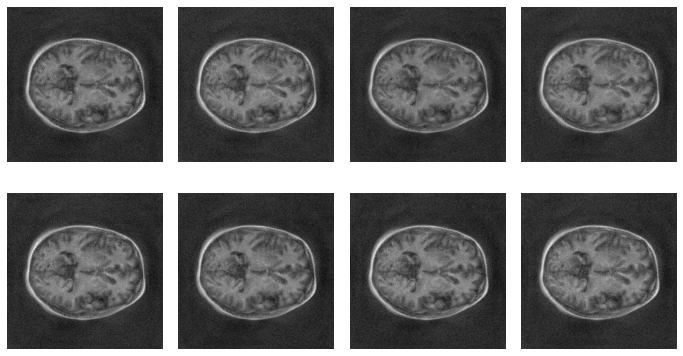

In [151]:
more_noise = tf.random.normal([batch_size, im_size, im_size, 1])

w = []
z = noiseList(batch_size)
for z in z:
    w.append(S(z))

images = G((w, more_noise))

fig = plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=-0.6, wspace=0.1)
plt.show()

In [150]:
truncated_w = []
for w in w:
    truncated_w.append(truncate(w,0))
print(truncated_w[0])
images = G((truncated_w, more_noise))

fig = plt.figure(figsize=(12,12))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i, :, :, 0], cmap='gray')
    plt.axis('off')

plt.subplots_adjust(hspace=-0.6, wspace=0.1)
plt.show()

print(images)

tf.Tensor(
[[-0.02737158  0.5112424  -0.0446452  ...  0.673839   -0.10778923
  -0.13874798]
 [-0.02737158  0.5112424  -0.0446452  ...  0.673839   -0.10778923
  -0.13874798]
 [-0.02737158  0.5112424  -0.0446452  ...  0.673839   -0.10778923
  -0.13874798]
 ...
 [-0.02737158  0.5112424  -0.0446452  ...  0.673839   -0.10778923
  -0.13874798]
 [-0.02737158  0.5112424  -0.0446452  ...  0.673839   -0.10778923
  -0.13874798]
 [-0.02737158  0.5112424  -0.0446452  ...  0.673839   -0.10778923
  -0.13874798]], shape=(8, 512), dtype=float32)
tf.Tensor(
[[[[-0.91191053]
   [-0.9935751 ]
   [-1.2326784 ]
   ...
   [-0.97616637]
   [-1.1167164 ]
   [-1.0530779 ]]

  [[-0.91252244]
   [-1.0273496 ]
   [-0.93944   ]
   ...
   [-1.1582627 ]
   [-1.2970281 ]
   [-1.1191379 ]]

  [[-0.8193482 ]
   [-1.0252378 ]
   [-1.1797721 ]
   ...
   [-0.9612633 ]
   [-1.0754871 ]
   [-0.9735489 ]]

  ...

  [[-0.8652239 ]
   [-0.98919713]
   [-1.0586634 ]
   ...
   [-0.97300303]
   [-0.8883047 ]
   [-0.98815894]]

  [